<a href="https://colab.research.google.com/github/AdityaTanejaRox/SpamEmailClassification/blob/main/Bayes_Classifier_(1).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**#NOTEBOOK IMPORTS**

In [ ]:
from os import walk
from os.path import join
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import nltk
from nltk.stem import PorterStemmer
from nltk.stem import SnowballStemmer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from bs4 import BeautifulSoup
from wordcloud import WordCloud
from PIL import Image
from sklearn.model_selection import train_test_split

**CONSTANTS**

In [ ]:
EXAMPLE_FILE = 'SpamData/01_Processing/practice_email.txt'

SPAM_1_PATH = 'SpamData/01_Processing/spam_assassin_corpus/spam_1'

SPAM_2_PATH = 'SpamData/01_Processing/spam_assassin_corpus/spam_2'

EASY_NONSPAM_1_PATH = 'SpamData/01_Processing/spam_assassin_corpus/easy_ham_1'

EASY_NONSPAM_2_PATH = 'SpamData/01_Processing/spam_assassin_corpus/easy_ham_2'

SPAM_CAT = 1 #spam 
HAM_CAT = 0 #non-spam
VOCAB_SIZE = 2500

DATA_JSON_FILE = 'SpamData/01_Processing/email-text-data.json'
WORD_ID_FILE = 'SpamData/01_Processing/word-by-id.csv'

TRAINING_DATA_FILE = 'SpamData/02_Training/train-data.txt'
TEST_DATA_FILE = 'SpamData/02_Training/test-data.txt'

WHALE_FILE = 'SpamData/01_Processing/wordcloud_resources/whale-icon.png'
SKULL_FILE = 'SpamData/01_Processing/wordcloud_resources/skull-icon.png'
THUMBS_UP =  'SpamData/01_Processing/wordcloud_resources/thumbs-up.png'
THUMBS_DOWN =  'SpamData/01_Processing/wordcloud_resources/thumbs-down.png'

**READING FILES**

In [ ]:
stream = open(EXAMPLE_FILE, encoding = 'latin-1')
is_body = False
lines = []
for line in stream:
    if is_body:
        lines.append(line)
    elif line=='\n':
        is_body = True
        
stream.close()

email_body = '\n'.join(lines)
print(email_body)



Dear Mr Still



Good tidings to you and all your staff for the festive season ahead (Christmas).

Now to the crux of the matter-in-hand: I am a fully qualified Santa Claus and am wondering whether you might consider me to run my own "Santa's Grotto" in your store.

But WAIT! You're probably thinking: "What makes him so special?"

Well, first of all, I have made several changes to the characterisation of Father Christmas. Rather than greeting the children with shouts of "Ho, ho, ho!" I prefer to whisper the phrase "Dependence is not unfathomable in this cruel world we live in". In addition, my gifts are ALL hand-made, ranging from felt hoops to vanilla-pod holders.

You will note also, from the enclosed sketch, that I have radically redesigned Santa's outfit and have renamed my character "Lord Buckles". Would you be interested in employing me? I promise NEVER to let you down.

I look forward to hearing from you.



Best wishes

Robin Cooper

[Excerpt from the book: The Timewaster Let

**#GENERATOR FUNCTION**


In [ ]:
def generate_squares(N):
    for my_number in range(N):
        yield my_number ** 2 #yield returns the value while remembering the value it exited on. 
        

**#EMAIL BODY EXTRACTOR**

In [ ]:
def email_body_generator(path):
    for root, dirnames, file_names in walk(path):
        for file_name in file_names:
            
            filepath = join(root, file_name)
            stream = open(filepath, encoding = 'latin-1')
            is_body = False
            lines = []
            for line in stream:
                if is_body:
                   lines.append(line) 
                elif line=='\n':
                    is_body = True

            stream.close()

            email_body = '\n'.join(lines)
            yield file_name, email_body

In [ ]:
def df_from_directory(path, classification):
    rows = []
    row_names = []
    
    for file_name, email_body in email_body_generator(path):
            rows.append({'MESSAGE': email_body, 'CATEGORY': classification})
            row_names.append(file_name)
            
    return pd.DataFrame(rows, index=row_names)        

In [ ]:
spam_emails = df_from_directory(SPAM_1_PATH, SPAM_CAT)
spam_emails = spam_emails.append(df_from_directory(SPAM_2_PATH, SPAM_CAT))
spam_emails.head()

,MESSAGE,CATEGORY
00001.7848dde101aa985090474a91ec93fcf0,"<!DOCTYPE HTML PUBLIC ""-//W3C//DTD HTML 4.0 Tr...",1
00002.d94f1b97e48ed3b553b3508d116e6a09,1) Fight The Risk of Cancer!\n\nhttp://www.adc...,1
00003.2ee33bc6eacdb11f38d052c44819ba6c,1) Fight The Risk of Cancer!\n\nhttp://www.adc...,1
00004.eac8de8d759b7e74154f142194282724,##############################################...,1
00005.57696a39d7d84318ce497886896bf90d,I thought you might like these:\n\n1) Slim Dow...,1


In [ ]:
spam_emails.shape

(1898, 2)

In [ ]:
ham_emails = df_from_directory(EASY_NONSPAM_1_PATH, HAM_CAT)
ham_emails = ham_emails.append(df_from_directory(EASY_NONSPAM_2_PATH, HAM_CAT))
ham_emails.shape

(3901, 2)

In [ ]:
data = pd.concat([spam_emails, ham_emails])
print("Shape of entire dataframe is ", data.shape)

Shape of entire dataframe is  (5799, 2)


**#DATA CLEANING AND CHECKING FOR MISSING VALUES**

In [ ]:
#check if message body == null.
data['MESSAGE'].isnull().values.any()

False

In [ ]:
#check if there are empty emails i.e str.len = 0
(data.MESSAGE.str.len() == 0).any()

True

In [ ]:
(data.MESSAGE.str.len() == 0).sum()

3

In [ ]:
data.MESSAGE.isnull().sum()

0

**#LOCATE EMPTY EMAILS**

In [ ]:
data[data.MESSAGE.str.len() == 0].index

Index(['cmds', 'cmds', 'cmds'], dtype='object')

In [ ]:
data.index.get_loc('cmds')

array([False, False, False, ..., False, False, False])

**#REMOVE SYSTEM FILE ENTRIES FROM DATAFRAME**

In [ ]:
data.shape


(5799, 2)

**#ADD DOCUMENT IDS TO TRACK EMAILS IN THE DATASET**

In [ ]:
document_ids = range(0, len(data.index))
data['DOC_ID'] = document_ids

In [ ]:
data['FILE_NAME'] = data.index
data = data.set_index('DOC_ID')
data.head()

,MESSAGE,CATEGORY,FILE_NAME
DOC_ID,,,
0,"<!DOCTYPE HTML PUBLIC ""-//W3C//DTD HTML 4.0 Tr...",1,00001.7848dde101aa985090474a91ec93fcf0
1,1) Fight The Risk of Cancer!\n\nhttp://www.adc...,1,00002.d94f1b97e48ed3b553b3508d116e6a09
2,1) Fight The Risk of Cancer!\n\nhttp://www.adc...,1,00003.2ee33bc6eacdb11f38d052c44819ba6c
3,##############################################...,1,00004.eac8de8d759b7e74154f142194282724
4,I thought you might like these:\n\n1) Slim Dow...,1,00005.57696a39d7d84318ce497886896bf90d


In [ ]:
data.tail()

,MESSAGE,CATEGORY,FILE_NAME
DOC_ID,,,
5794,http://news.bbc.co.uk/1/hi/england/2515127.stm...,0,01396.61983fbe6ec43f55fd44e30fce24ffa6
5795,"> >-- be careful when using this one.) Also, t...",0,01397.9f9ef4c2a8dc012d80f2ce2d3473d3b7
5796,">>>>> ""SM"" == Skip Montanaro <skip@pobox.com> ...",0,01398.169b51731fe569f42169ae8f948ec676
5797,"So then, ""Mark Hammond"" <mhammond@skippinet.co...",0,01399.ca6b00b7b341bbde9a9ea3dd6a7bf896
5798,"Hi there,\n\n\n\nNow this is probably of no us...",0,01400.f897f0931e461e7b2e964d28e927c35e


**#SAVE TO FILE USING PANDAS**

In [ ]:
data.to_json(DATA_JSON_FILE)

**#NUMBER OF SPAM MESSAGES VISUALIZED (PIE CHARTS)** 

In [ ]:
data.CATEGORY.value_counts()

0    3901
1    1898
Name: CATEGORY, dtype: int64

In [ ]:
amount_of_spam = data.CATEGORY.value_counts()[1]
amount_of_ham = data.CATEGORY.value_counts()[0]

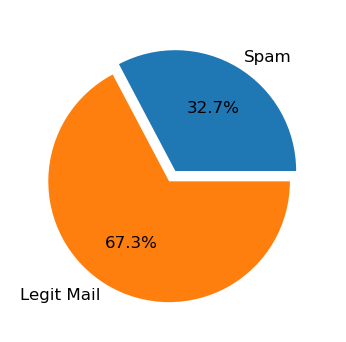

In [ ]:
category_names = ['Spam', 'Legit Mail']
sizes = [amount_of_spam, amount_of_ham]

plt.figure(figsize=(2,2), dpi=200)
plt.pie(sizes, labels=category_names, textprops={'fontsize':6}, autopct='%1.1f%%', explode=[0,0.1])
plt.show()

**#NATURAL LANGUAGE PROCESSING**

**Text Pre-Processing**

#**DOWNLOADING THE NLTK RESOURCES (Tokenizer & Stopwords)**

In [ ]:
nltk.download('punkt')

NameError: ignored

In [ ]:
nltk.download('stopwords')

In [ ]:
nltk.download('gutenberg')
nltk.download('shakespeare')

**#REMOVING STOPWORDS**

In [ ]:
stop_words = set(stopwords.words('english'))

In [ ]:
msg = "All work and no play makes Aditya a dull boy."
words = word_tokenize(msg.lower())

stemmer = PorterStemmer()

filtered_words = []
for word in words:
    if word not in stop_words:
        stemmed_word = stemmer.stem(word)
        filtered_words.append(stemmed_word)
print(filtered_words)        

**#WORD STEMMING**

In [ ]:
msg = "All work and no play makes Aditya a dull boy."
words = word_tokenize(msg.lower())

stemmer = PorterStemmer()

filtered_words = []
for word in words:
    if word not in stop_words:
        stemmed_word = stemmer.stem(word)
        filtered_words.append(stemmed_word)
print(filtered_words)        

**#REMOVING PUNCTUATIONS**

In [ ]:
msg = "All work and no play makes Aditya a dull boy.???"
words = word_tokenize(msg.lower())

stemmer = SnowballStemmer('english')

filtered_words = []
for word in words:
    if word not in stop_words and word.isalpha():
        stemmed_word = stemmer.stem(word)
        filtered_words.append(stemmed_word)
print(filtered_words)        

**#REMOVING HTML TAGS**

In [ ]:
soup = BeautifulSoup(data.at[2, 'MESSAGE'], 'html.parser')
print(soup.prettify())

In [ ]:
soup.get_text()

**#FUNCTIONS FOR EMAIL PROCESSING**

In [ ]:
def clean_message(message, stemmer = PorterStemmer(), stop_words = set(stopwords.words('english'))):
    words = word_tokenize(message.lower())
    
    filtered_words = []
    
    for word in words:
        if word not in stop_words and word.isalpha():
            filtered_words.append(stemmer.stem(word))
    
    return filtered_words

In [ ]:
clean_message(email_body)

In [ ]:
def clean_message_no_html(message, stemmer = PorterStemmer(), stop_words = set(stopwords.words('english'))):
    
    soup = BeautifulSoup(message, 'html.parser')
    cleaned_text = soup.get_text()
    
    words = word_tokenize(cleaned_text.lower())
    
    filtered_words = []
    
    for word in words:
        if word not in stop_words and word.isalpha():
            filtered_words.append(stemmer.stem(word))
    
    return filtered_words

In [ ]:
clean_message_no_html(data.at[2, 'MESSAGE'])

**#APPLY CLEANING AND TOKENIZATION TO ALL EMAILS**

**Slicing Dataframes and Series & Creating Subsets**

In [ ]:
data.iloc[5:11]

In [ ]:
first_emails = data.MESSAGE.iloc[0:3]

nested_list = first_emails.apply(clean_message)

In [ ]:
# flat_list = []
# for sublist in nested_list:
#     for item in sublist:
#         flat_list.append(item)
        
flat_list = [item for sublist in nested_list for item in sublist]

    
len(flat_list)  

In [ ]:
%%time

nested_list = data['MESSAGE'].apply(clean_message_no_html)

In [ ]:
nested_list.head()

**#USING LOGIC TO SLICE DATAFRAMES**

In [ ]:
data[data.CATEGORY == 1].shape

In [ ]:
doc_ids_spam = data[data.CATEGORY == 1].index
doc_ids_ham = data[data.CATEGORY == 0].index

**#SUBSETTING SERIES WITH AN INDEX**

In [ ]:
nested_list_ham = nested_list.loc[doc_ids_ham]
nested_list_spam = nested_list.loc[doc_ids_spam]

In [ ]:
flat_list_ham = [item for sublist in nested_list_ham for item in sublist]
normal_words = pd.Series(flat_list_ham).value_counts()

normal_words.shape[0] #total no.of unique words in non-spam messages


In [ ]:
normal_words[:10]

In [ ]:
flat_list_spam = [item for sublist in nested_list_spam for item in sublist]
spammy_words = pd.Series(flat_list_spam).value_counts()

spammy_words.shape[0] #total no.of unique words in spam messages


In [ ]:
spammy_words[:10]

**#Creating a Wordcloud**

In [ ]:
word_cloud = WordCloud().generate(email_body)
plt.imshow(word_cloud, interpolation='bilinear')
plt.axis('off')
plt.show()

In [ ]:
example_corpus = nltk.corpus.gutenberg.words('melville-moby_dick.txt')

In [ ]:
word_list = [''.join(word) for word in example_corpus]
novel_as_string = ' '.join(word_list)

In [ ]:
icon = Image.open(WHALE_FILE)
image_mask = Image.new(mode='RGB', size=icon.size, color=(255,255,255))
image_mask.paste(icon, box=icon)

rgb_array = np.array(image_mask) #converts image object to an array.

word_cloud = WordCloud(mask=rgb_array, background_color='cyan',max_words=100, colormap='ocean')
word_cloud.generate(novel_as_string)

plt.figure(figsize=[16, 8])
plt.imshow(word_cloud, interpolation='bilinear')
plt.axis('off')
plt.show()

In [ ]:
hamlet_corpus = nltk.corpus.gutenberg.words('shakespeare-hamlet.txt')
word_list = [''.join(word) for word in hamlet_corpus]
hamlet_as_string = ' '.join(word_list)

skull_icon = Image.open(SKULL_FILE)
image_mask = Image.new(mode='RGB', size=skull_icon.size, color=(255, 255, 255))
image_mask.paste(skull_icon, box=skull_icon)
rgb_array = np.array(image_mask)

word_cloud = WordCloud(mask=rgb_array, background_color='white', colormap='bone', max_words=600)
word_cloud.generate(hamlet_as_string)

plt.figure(figsize=[16, 8])
plt.imshow(word_cloud, interpolation='bilinear')
plt.axis('off')
plt.show()

**#WORD CLOUD OF HAM AND SPAM MESSAGES**

In [ ]:
icon = Image.open(THUMBS_UP)
image_mask = Image.new(mode='RGB', size=icon.size, color=(255,255,255))
image_mask.paste(icon, box=icon)

rgb_array = np.array(image_mask) #converts image object to an array.

ham_str = ' '.join(flat_list_ham)

word_cloud = WordCloud(mask=rgb_array, background_color='black',max_words=500, colormap='winter')
word_cloud.generate(ham_str)

plt.figure(figsize=[16, 8])
plt.imshow(word_cloud, interpolation='bilinear')
plt.axis('off')
plt.show()

In [ ]:
icon = Image.open(THUMBS_DOWN)
image_mask = Image.new(mode='RGB', size=icon.size, color=(255,255,255))
image_mask.paste(icon, box=icon)

rgb_array = np.array(image_mask) #converts image object to an array.

spam_str = ' '.join(flat_list_spam)

word_cloud = WordCloud(mask=rgb_array, background_color='white',max_words=500, colormap='gist_heat')
word_cloud.generate(spam_str)

plt.figure(figsize=[16, 8])
plt.imshow(word_cloud, interpolation='bilinear')
plt.axis('off')
plt.show()

**#GENERATE VOCABULARY AND DICTIONARY**

In [ ]:
stemmed_nested_list = data.MESSAGE.apply(clean_message_no_html)
flat_stemmed_list = (item for sublist in stemmed_nested_list for item in sublist)

In [ ]:
unique_words = pd.Series(flat_stemmed_list).value_counts()
print("No.of unique words :", unique_words.shape[0])

In [ ]:
frequent_words = unique_words[0:VOCAB_SIZE]
print('Most common words :', frequent_words[:10])

**#CREATE VOCABULARY DATAFRAME WITH WORD IDS**

In [ ]:
word_ids = list(range(0, VOCAB_SIZE))
vocab = pd.DataFrame({'VOCAB_WORD': frequent_words.index.values}, index=word_ids)
vocab.index.name = 'WORD_ID'
vocab.head()

**SAVES THE VOCABULARY AS A CSV FILE**

In [ ]:
vocab.to_csv(WORD_ID_FILE, index_label=vocab.index.name, header=vocab.VOCAB_WORD.name)

**#EXERCISE : CHECKING IF THE WORD EXISTS IN THE VOCABULARY**

In [ ]:
'machine' in set(vocab.VOCAB_WORD)

**FINDING EMAIL WITH MOST NO.OF WORDS**

In [ ]:
clean_email_length = [len(sublist) for sublist in stemmed_nested_list]
print('No.of words in the longest email:', max(clean_email_length))

In [ ]:
print('Email position in the list (and the data dataframe):', np.argmax(clean_email_length))

In [ ]:
stemmed_nested_list[5778]

In [ ]:
data.at[np.argmax(clean_email_length), 'MESSAGE']

**#GENERATE FEATURES AND SPARSE MATRIX**

**Creating a Dataframe with One Word Per column**

In [ ]:
type(stemmed_nested_list)

In [ ]:
type(stemmed_nested_list.tolist())

In [ ]:
word_columns_df = pd.DataFrame.from_records(stemmed_nested_list.tolist())
word_columns_df.head()

**#SPLITTING THE DATA INTO TRAINING AND TESTING DATASET**

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(word_columns_df, data.CATEGORY, test_size=0.3, random_state=42)

In [ ]:
print('No.of training samples', x_train.shape[0])
print('Fraction of training set', x_train.shape[0] / word_columns_df.shape[0])

In [ ]:
x_train.index.name = x_test.index.name = 'DOC_ID'
x_train.head()

In [ ]:
y_train.head()

**#CREATE A SPARSE MATRIX FOR TRAINING DATA**

In [ ]:
word_index = pd.Index(vocab.VOCAB_WORD)

In [ ]:
def make_sparse_matrix(df, indexed_words, labels):
    """
       Returns Sparse Matrix as dataframe.
    
       df: is a data frame with words in column with a document id as an index (x_train or x_test)
       indexed_words: index of words ordered by word id
       labels: category as a series (y_train or y_test)
    """
    nr_rows = df.shape[0]
    nr_cols = df.shape[0]
    word_set = set(indexed_words)
    dict_list = []
    
    for i in range(nr_rows):
        for j in range(nr_cols):
            word = df.iat[i, j]
            if word in word_set:
                doc_id = df.index[i]
                word_id = indexed_words.get_loc(word)
                category = labels.at[doc_id]
                
                item = {'LABEL': category, 'DOC_ID': doc_id, 'OCCURENCE': 1, 'WORD_ID': word_id}
                
                dict_list.append(item)
    
    return pd.DataFrame(dict_list)

In [ ]:
%%time 
sparse_train_df = make_sparse_matrix(x_train, word_index, y_train)

In [ ]:
sparse_train_df[:5]

In [ ]:
sparse_train_df.shape

In [ ]:
sparse_train_df[-5:]

**#COMBINE OCCURENCES WITH PANDAS GROUPBY METHOD**

In [ ]:
train_grouped = sparse_train_df.groupby(['DOC_ID', 'WORD_ID','LABEL']).sum()
train_grouped.head()

In [ ]:
vocab.at[0, 'VOCAB_WORD']

In [ ]:
data.MESSAGE[0]

In [ ]:
train_grouped = train_grouped.reset_index()
train_grouped.head()

In [ ]:
train_grouped.tail()

In [ ]:
vocab.at[2033, 'VOCAB_WORD']

In [ ]:
data.MESSAGE[5798]

In [ ]:
train_grouped.shape

**#SAVING TRAINING DATA AS .txt FILE**

In [ ]:
np.savetxt(TRAINING_DATA_FILE, train_grouped, fmt='%d')

In [ ]:
train_grouped.columns

In [ ]:
x_test.head()

In [ ]:
y_test.head()

In [ ]:
x_test.shape

In [ ]:
%%time
sparse_test_df = make_sparse_matrix(x_test, word_index, y_test)

In [ ]:
sparse_test_df.shape

In [ ]:
test_grouped = sparse_test_df.groupby(['DOC_ID', 'WORD_ID', 'LABEL']).sum().reset_index()
test_grouped.head()

In [ ]:
test_grouped.shape

In [ ]:
np.savetxt(TEST_DATA_FILE, test_grouped, fmt='%d')